# Project - Food data Analysis and Model

한국관광공사에서 공공데이터로 제공하는 자료를 활용하여 소개하는 Text 개요를 통하여 음식종류의 카테고리를 예측하는 자연어 분석 진행

---

### Import

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from konlpy.tag import Twitter
import lightgbm as lgb
from sklearn.preprocessing import Imputer
from sklearn import preprocessing
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')

### Data Setting

In [3]:
def Food_data_setting():
    food = pd.read_csv("한국관광공사_전국_음식점_정보_20160906.csv",sep=None ,encoding="cp949")
    food = food.filter(items=['카테고리3', '개요'])
    food = food.dropna()
    
    return food

food = Food_data_setting()

In [4]:
food.tail()

,카테고리3,개요
6104,한식,경기도 일산에서 가장 오랜되고 맛있는 집으로 소문난 집이다. 13년동안 한곳에서 한...
6105,한식,팔팔민물장어는 30년 전통으로 오직 장어만을 전문으로 하는 장어전문 요리집이다. 3...
6106,서양식,서울스퀘어에 자리잡은 크라제버거. 1998년 11월 압구정동에 국내에서는 처음으로...
6107,서양식,이태리식 레스토랑으로써 음식에 사용되는 모든 신선한 재료들을 그릴(숯을 이용)에 한...
6108,한식,경상북도 청송군 청송읍 부곡리에 위치한 봉산식당은 달기약수를 이용한 백숙을 전문으로...


In [5]:
food['카테고리3'].value_counts()

한식         4872
서양식         314
카페/전통찻집     274
중식          242
일식          181
아시아식        101
패밀리레스토랑      39
이색음식점        26
채식전문점        25
Name: 카테고리3, dtype: int64

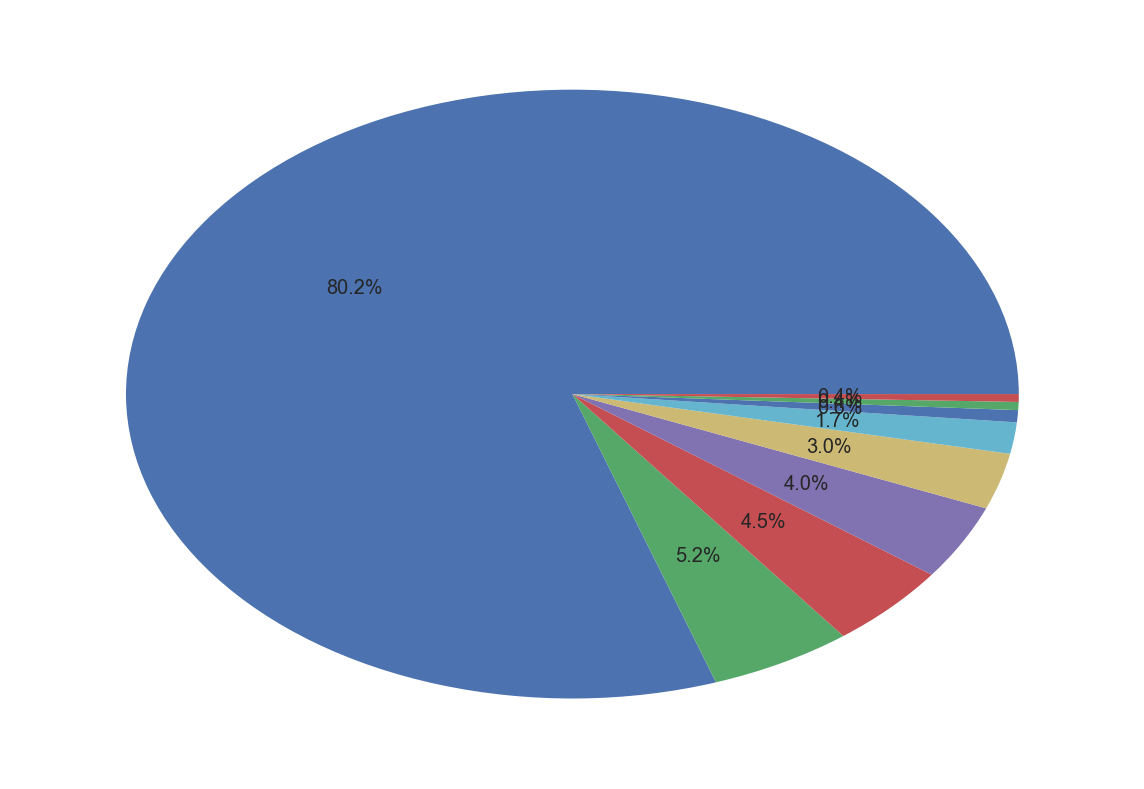

In [40]:
# 구성 비율 체크 (Pie chart)

total_v = food['카테고리3'].value_counts()
fig = plt.figure(figsize = (10,7))
plt.pie(total_v ,autopct='%1.1f%%')
plt.show()

---

### '개요' Text 분석

In [6]:
from konlpy.tag import Twitter
from konlpy.tag import *
hannanum = Hannanum()
kkma = Kkma()
twitter = Twitter()

def tokenize_pos(doc):
    return ['/'.join(t) for t in twitter.pos(doc)]

In [7]:
# Pipeline 구축

clf = Pipeline([
    ("vect", TfidfVectorizer(tokenizer=tokenize_pos, ngram_range=(1,2))), 
    ("clf", MultinomialNB(alpha=0.01))
])

In [8]:
# 데이터 split

X_train, X_test, y_train, y_test = train_test_split(food['개요'], food['카테고리3'], \
                                                    test_size=0.4, random_state=0)

len(X_train),len(X_test),len(y_train),len(y_test)

(3644, 2430, 3644, 2430)

Train 

Train confusion_matrix 

[[ 191    1    0    0    0    0    0    0    0]
 [   0   65    0    0    0    0    0    0    0]
 [   0    0   14    0    0    0    0    0    0]
 [   0    0    0  105    0    0    0    0    0]
 [   0    0    0    0  149    0    0    0    0]
 [   0    0    0    0    0   16    0    0    0]
 [   0    0    0    0    0    0  163    0    0]
 [   0    0    0    0    0    0    0   23    0]
 [   0    0    0    3    0    0    0    0 2914]] 


Train classification_report 

             precision    recall  f1-score   support

        서양식       1.00      0.99      1.00       192
       아시아식       0.98      1.00      0.99        65
      이색음식점       1.00      1.00      1.00        14
         일식       0.97      1.00      0.99       105
         중식       1.00      1.00      1.00       149
      채식전문점       1.00      1.00      1.00        16
    카페/전통찻집       1.00      1.00      1.00       163
    패밀리레스토랑       1.00      1.00      1.00        23
         한식       1.00 

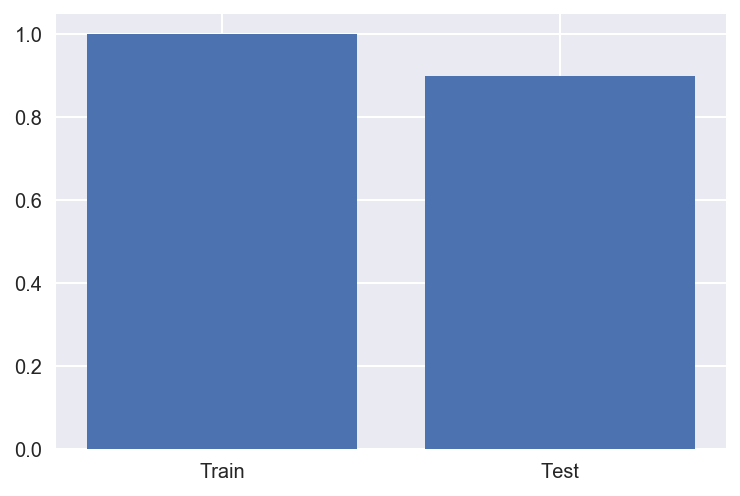

In [9]:
# def Food():

model  = clf.fit(X_train, y_train)

y_pred  = model.predict(X_train)

print("Train", "\n")
print("Train confusion_matrix", "\n")
print(confusion_matrix(y_train, y_pred), "\n\n")
print("Train classification_report", "\n")
print(classification_report(y_train, y_pred), "\n\n")
print("Train accuracy_score", "\n")
print(round(accuracy_score(y_train, y_pred), 2), "\n\n")

print("=====================================================" , "\n\n")

y_pred_t = model.predict(X_test)

print("Test", "\n")
print("Test confusion_matrix", "\n")
print(confusion_matrix(y_test, y_pred_t), "\n\n")
print("Test classification_report", "\n")
print(classification_report(y_test, y_pred_t), "\n\n")
print("Test accuracy_score", "\n")
print(round(accuracy_score(y_test, y_pred_t), 2), "\n\n")

x="Train","Test"
y=accuracy_score(y_train, y_pred), accuracy_score(y_test, y_pred_t)
plt.bar(x,y)
plt.show()

{0, 1, 2, 3, 4, 5, 6, 7, 8}
['서양식', '아시아식', '이색음식점', '일식', '중식', '채식전문점', '카페/전통찻집', '패밀리레스토랑', '한식']


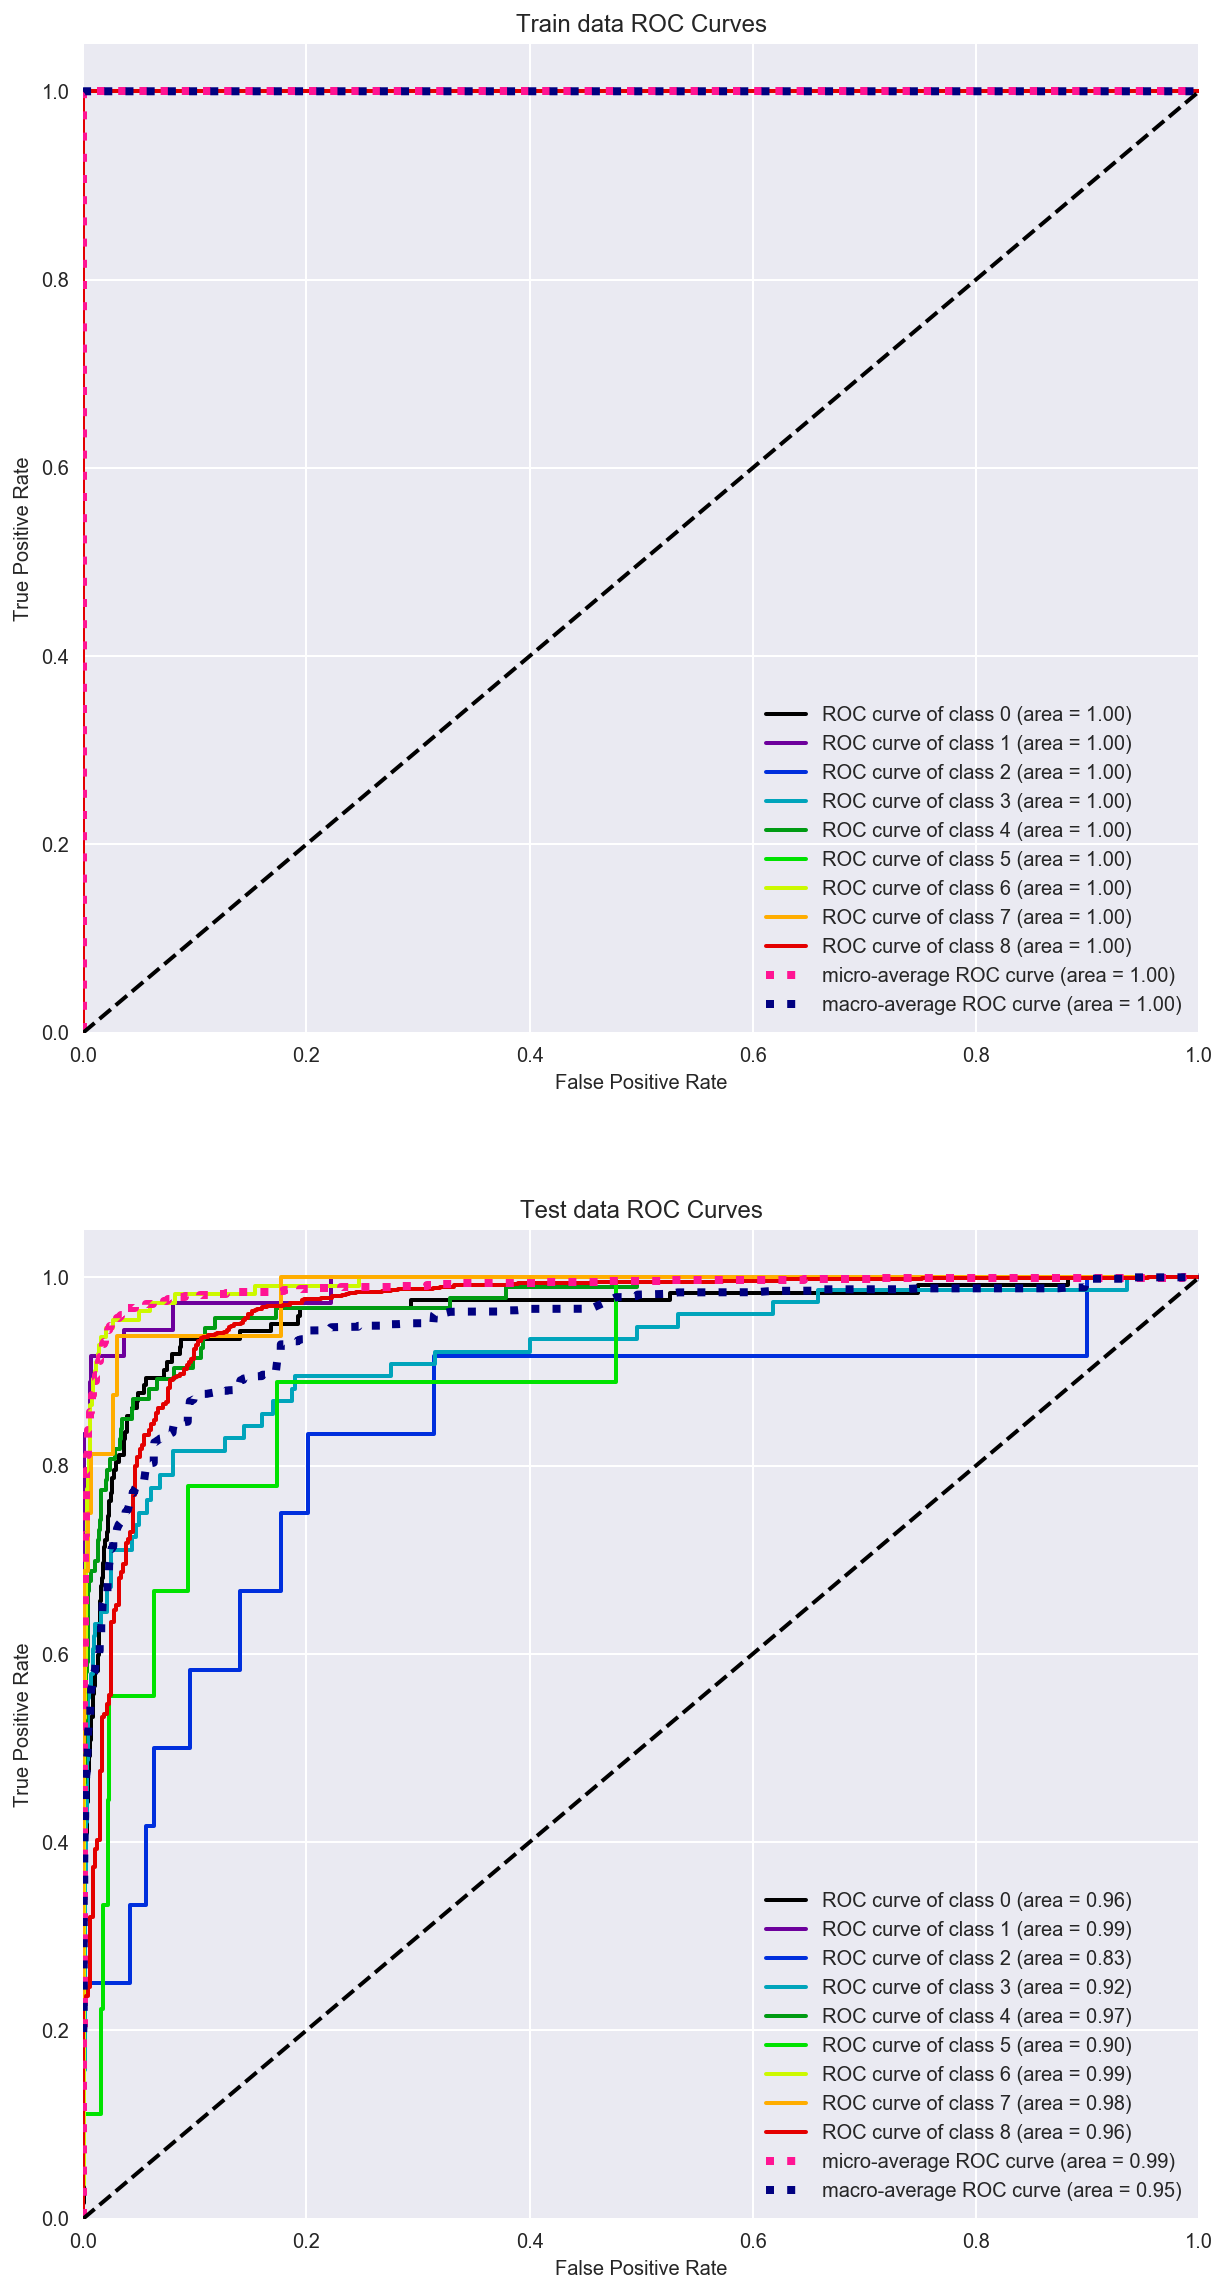

In [14]:
# ROC 민감도 체크

# Labeling
le = preprocessing.LabelEncoder()
y_label = le.fit_transform(food['카테고리3'])

# re split
X_train, X_test, y_train, y_test = train_test_split(food['개요'], y_label, test_size=0.4, random_state=0)

# Labeling inverse
print(set(y_label))
print(sorted(set(le.inverse_transform(y_label))))

# ROC
import scikitplot as skplt

fig = plt.figure(figsize=(10, 20))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

y_probas = model.predict_proba(X_train)
y_probas_T = model.predict_proba(X_test)

skplt.metrics.plot_roc_curve(y_train, y_probas, ax=ax1, title='Train data ROC Curves')

skplt.metrics.plot_roc_curve(y_test, y_probas_T, ax=ax2, title='Test data ROC Curves')

plt.show()

### 문구 Test

In [11]:
X_=pd.Series("피자")

y_pred_t = model.predict_proba(X_)
y_pred = model.predict(X_)

print(y_pred_t)
print(y_pred)

[[8.28887169e-01 1.89651581e-02 3.15902769e-04 1.45326892e-03
  1.79545080e-03 3.49206028e-04 4.67012381e-02 7.20823340e-03
  9.43243727e-02]]
['서양식']


In [12]:
X_=pd.Series(str(input("insert 1number : ")))

y_pred_t = model.predict_proba(X_)
y_pred = model.predict(X_)

print(y_pred_t)
print(y_pred)

insert 1number : 냉면
[[5.14779783e-04 2.96753581e-04 8.86942263e-05 1.06287749e-02
  5.04098524e-04 9.80445931e-05 3.38182960e-03 1.36156216e-04
  9.84350869e-01]]
['한식']


---

**Food_Category_Analysis 분석 결과**
 - 음식을 소개하는 자연어(개요)를 통하여 음식의 카테고리를 분류하는 분석을 진행해 보았다.
 - 6000여개 데이터 가운데 80%가 한식이지만 accuracy는 90%로 나왔고 recall rate은 한식을 제외하고 낮기때문에 주의해야한다.
 - recall rate은 train data의 불균형 때문이라고 판단되며, 이를 해소하기 위해서는 한식 data under sampling을 통하여 비율을 맞춰 준다면 해결가능할것으로 예상된다.
 - 이번 분석은 original data의 손실없이 최대한 활용하여 분석을 시도한 것으로 recall rate은 감수해야했다.
 - 하지만 음식 소개의 특징은 각자 가지고있기 때문에 그대로 분석을 실행해보았다. (피자 - 서양식 o , 한식 x)
 
 **이번 분석을 통하여 원하는 음식이 어느 카테고리에 들어가는지 확률적으로 예측이 가능하다.**

**Copyright ⓒ 2018 by ParkSungho All Pictures cannot be copied without permission**